In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import os

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Import data loading and preprocessing utilities
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

# Define key parameters
DATA_DIR = '/kaggle/input/training/train/'
IMG_HEIGHT = 224  # Using a standard size like 224x224 is good for transfer learning
IMG_WIDTH = 224
BATCH_SIZE = 32   # Number of images to process in one batch
EPOCHS = 20       # Number of times to iterate over the entire dataset

2025-10-24 04:10:58.150198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761279058.549814      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761279058.681155      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Load the dataset from the directory
# This creates a dataset of (image, label) pairs
full_dataset = image_dataset_from_directory(
    DATA_DIR,
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Get class names
class_names = full_dataset.class_names
print("Class Names:", class_names)

# --- Create Train/Validation/Test Split ---
# We need to split the full_dataset (10,000 images)

# First, take 10% for the test set
test_batches = int(len(full_dataset) * 0.1)  # 10% for testing
test_set = full_dataset.take(test_batches)
train_val_set = full_dataset.skip(test_batches)

# From the remaining 90%, take ~11% (which is 10% of the original) for validation
val_batches = int(len(full_dataset) * 0.1) # 10% for validation
validation_set = train_val_set.take(val_batches)
train_set = train_val_set.skip(val_batches) # The rest is for training (~80%)

print(f"Total batches: {len(full_dataset)}")
print(f"Training batches: {len(train_set)}")
print(f"Validation batches: {len(validation_set)}")
print(f"Test batches: {len(test_set)}")

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

Found 6787 files belonging to 10 classes.


I0000 00:00:1761279083.002771      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761279083.003532      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Class Names: ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']
Total batches: 213
Training batches: 171
Validation batches: 21
Test batches: 21


In [ ]:
# Create a data augmentation layer
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)

# Create a normalization layer
normalization_layer = layers.Rescaling(1./255)

In [ ]:
# Build the model
model_1 = Sequential([
    # Input layer: Apply normalization
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    normalization_layer,
    
    # Apply data augmentation ONLY during training
    data_augmentation,
    
    # CNN Body
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Classifier Head
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5), # Dropout is another key technique to reduce overfitting 
    layers.Dense(len(class_names), activation='softmax') # Softmax for multi-class
], name="custom_cnn")

# Compile the model
model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # Standard loss for multi-class classification [cite: 26]
    metrics=['accuracy'] # This is Top-1 Accuracy [cite: 17]
)

model_1.summary()

# Train the model
history_1 = model_1.fit(
    train_set,
    validation_data=validation_set,
    epochs=EPOCHS
)

Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,426 (642.29 KB)

 Trainable params: 164,426 (642.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


I0000 00:00:1761279118.768048     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


171/171 ━━━━━━━━━━━━━━━━━━━━ 47s 66ms/step - accuracy: 0.1619 - loss: 2.2061 - val_accuracy: 0.2515 - val_loss: 2.0695
Epoch 2/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.2314 - loss: 2.1006 - val_accuracy: 0.3065 - val_loss: 2.0151
Epoch 3/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.2568 - loss: 2.0678 - val_accuracy: 0.3021 - val_loss: 1.9984
Epoch 4/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.2601 - loss: 2.0451 - val_accuracy: 0.2649 - val_loss: 2.0721
Epoch 5/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.2863 - loss: 1.9984 - val_accuracy: 0.2917 - val_loss: 1.9693
Epoch 6/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.2746 - loss: 2.0263 - val_accuracy: 0.3214 - val_loss: 1.9182
Epoch 7/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.2951 - loss: 1.9690 - val_accuracy: 0.3214 - val_loss: 1.9293
Epoch 8/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.3171 - loss: 1.9564 - val_accuracy: 0.33

In [ ]:
# 1. Load the pre-trained base model (without its top classification layer)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,  # Do NOT include the final 1000-neuron layer
    weights='imagenet'
)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create our new model on top
inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = normalization_layer(inputs) # Normalize first
x = data_augmentation(x) # Apply augmentation
x = base_model(x, training=False) # Run the base model (in inference mode)
x = layers.GlobalAveragePooling2D()(x) # Pool the features
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x) # Final output layer

model_2 = keras.Model(inputs, outputs, name="transfer_learning_resnet50")

# 4. Compile the model
model_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_2.summary()

# 5. Train the model (only the new layers)
history_2 = model_2.fit(
    train_set,
    validation_data=validation_set,
    epochs=EPOCHS
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "transfer_learning_resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,579,978 (13.66 MB)

 Trainable params: 1,321,994 (5.04 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.4760 - loss: 1.7091 - val_accuracy: 0.7158 - val_loss: 0.8378
Epoch 2/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.6604 - loss: 1.0374 - val_accuracy: 0.7336 - val_loss: 0.7819
Epoch 3/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.6877 - loss: 0.9605 - val_accuracy: 0.7560 - val_loss: 0.7543
Epoch 4/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.7127 - loss: 0.8909 - val_accuracy: 0.7426 - val_loss: 0.7498
Epoch 5/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.7287 - loss: 0.8122 - val_accuracy: 0.7604 - val_loss: 0.7355
Epoch 6/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.7281 - loss: 0.8074 - val_accuracy: 0.7440 - val_loss: 0.7863
Epoch 7/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.7388 - loss: 0.7725 - val_accuracy: 0.7634 - val_loss: 0.7368
Epoch 8/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.7626 - loss: 0.7214 - 

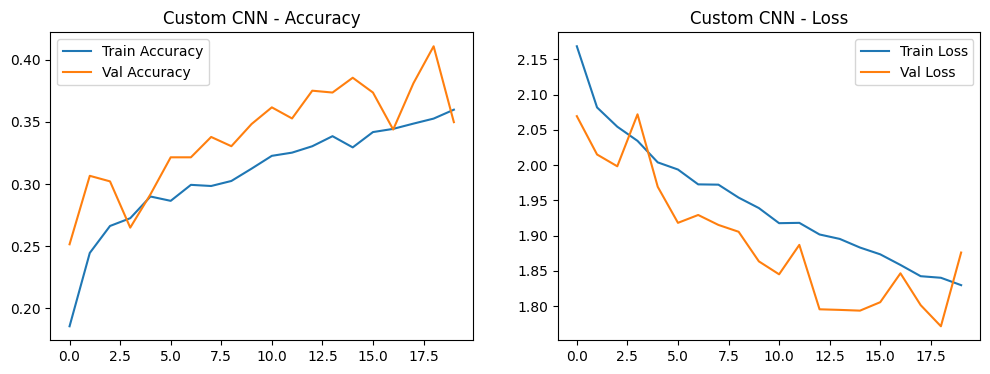

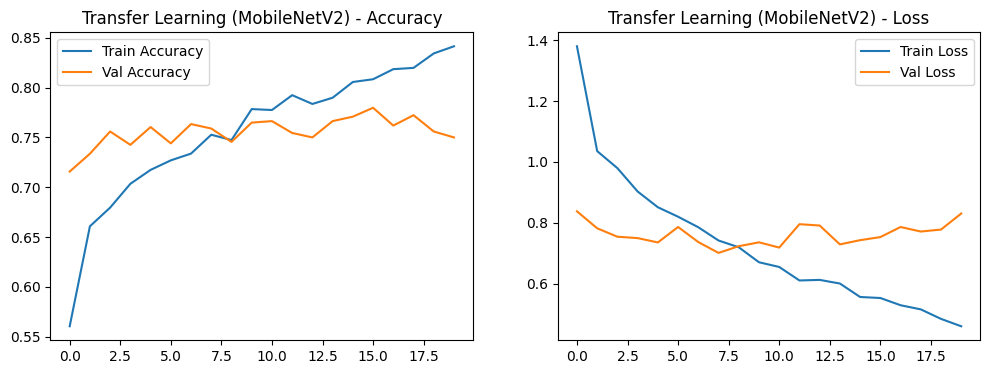

In [ ]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    
    plt.show()

plot_history(history_1, "Custom CNN")
plot_history(history_2, "Transfer Learning (MobileNetV2)")

In [ ]:
# Helper function to get all labels and predictions from the test set
def get_labels_and_predictions(model, test_dataset):
    y_true = []
    y_pred = []
    for images, labels in test_dataset:
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        preds = model.predict(images)
        y_pred.extend(np.argmax(preds, axis=1))
    return y_true, y_pred

# --- Model 1 Evaluation ---
print("--- Custom CNN Evaluation ---")
test_loss_1, test_acc_1 = model_1.evaluate(test_set)
print(f"Top-1 Test Accuracy: {test_acc_1:.4f}")

y_true_1, y_pred_1 = get_labels_and_predictions(model_1, test_set)
report_1 = classification_report(y_true_1, y_pred_1, target_names=class_names, output_dict=True)
avg_acc_1 = report_1['macro avg']['recall'] # In a balanced dataset, macro avg recall is avg accuracy per class
print(f"Average Accuracy per Class: {avg_acc_1:.4f}")

# --- Model 2 Evaluation ---
print("\n--- Transfer Learning (MobileV2) Evaluation ---")
test_loss_2, test_acc_2 = model_2.evaluate(test_set)
print(f"Top-1 Test Accuracy: {test_acc_2:.4f}")

y_true_2, y_pred_2 = get_labels_and_predictions(model_2, test_set)
report_2 = classification_report(y_true_2, y_pred_2, target_names=class_names, output_dict=True)
avg_acc_2 = report_2['macro avg']['recall']
print(f"Average Accuracy per Class: {avg_acc_2:.4f}")

--- Custom CNN Evaluation ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.3392 - loss: 1.9091
Top-1 Test Accuracy: 0.3214
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Average Accuracy per Class: 0.2555

--- Transfer Learning (MobileV2) 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7265 - loss: 0.8695
Top-1 Test Accuracy: 0.7336
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Average Accuracy per Class: 0.6901


In [ ]:
model_2.save('../models/best_model.h5')
print("Model saved to ../models/best_model.h5")

Model saved to ../models/best_model.h5
